# Actual Description

## Notebook for some test of the *stareg* package
1. Simulated data 1d
2. Simulated data 2d
3. Ebner data

In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from stareg import Bspline
from stareg import star_model, star_model_predict

# Legacy description

## Notebook for all the little code snippets for the code cleaning of *stareg*

TODOs:
- [x] B-spline
- [x] TP-Bspline
- [x] Penalty and smoothness matrices
- [x] check_constraint
- [x] star_model

I'll try to use as little external libraries as possible.

# 1. Test 1D Fit using B-spline, P-spline and SC-P-spline from *stareg*

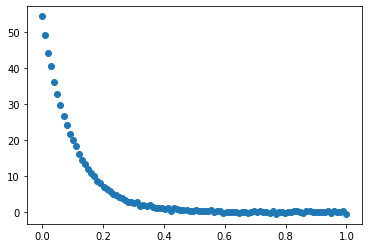

In [5]:
np.random.seed(2)
x = np.linspace(0,1,100)
xplot = np.linspace(0,1,100)
def f(x): return np.exp(-(x - 0.4)/ 0.1)
ytrue = f(x)
yplot = f(xplot)
y = ytrue + np.random.normal(scale=0.2, size=len(x))
plt.scatter(x,y)
BS = Bspline()

nr_splines = 100
l = 3
knot_type = "e"

 18%|███████████████████████▍                                                                                                          | 18/100 [00:00<00:00, 179.78it/s]

Inside Bspline.basismatrix()
Inside Bspline.basismatrix()


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 212.79it/s]


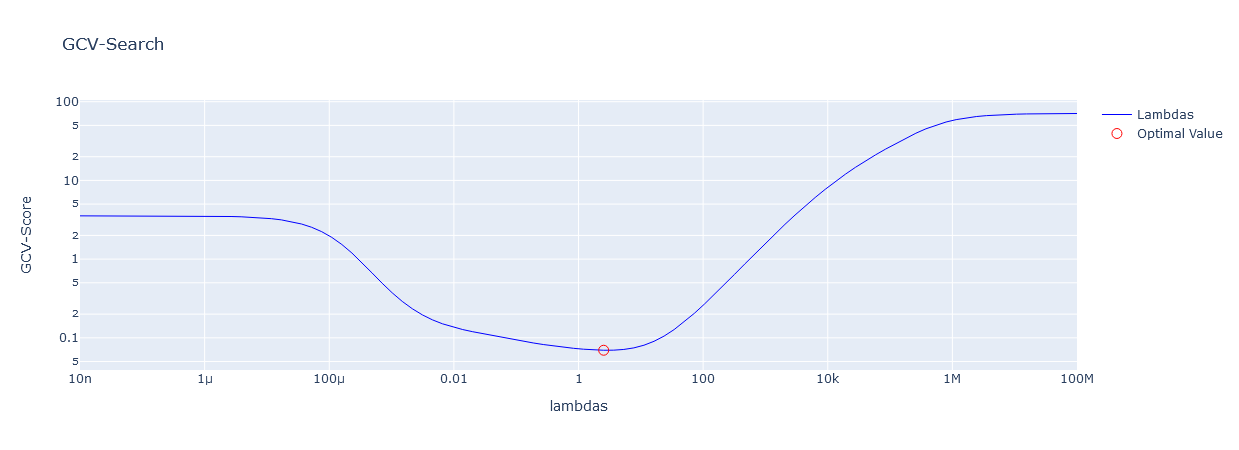

 21%|███████████████████████████▎                                                                                                      | 21/100 [00:00<00:00, 207.44it/s]

Best Lambda found =  2.5353644939701168
Inside Bspline.basismatrix()
Inside Bspline.basismatrix()


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 197.50it/s]

Inside Bspline.basismatrix()
========Pre-Iteration=========
-------MSE = 0.0369057--------
======== Iteration 1 =========
-------MSE = 0.0384917--------
======== Iteration 2 =========
-------MSE = 0.0389159--------
======== Iteration 3 =========
-------MSE = 0.0390006--------
======== Iteration 4 =========
--------MSE = 0.039014--------


In [6]:
Bs = BS.fit(X=x, y=y, nr_splines=nr_splines, l=l, knot_type=knot_type)
best_lam = BS.calc_GCV(X=x, y=y, nr_splines=nr_splines, l=l, knot_type=knot_type, nr_lam=100)["best_lambda"]
print("Best Lambda found = ", best_lam)
Ps = BS.fit_Pspline(X=x, y=y, nr_splines=nr_splines, l=l, knot_type=knot_type, lam=best_lam)
SCs = BS.fit_SC_Pspline(X=x, y=y, constraint="dec", nr_splines=nr_splines, l=l, knot_type=knot_type, lam_c=3000)

In [5]:
Bspred_plot = BS.predict(Xpred=xplot, coef=Bs["coef_"], knots=Bs["knots"], l=l)
Pspred_plot = BS.predict(Xpred=xplot, coef=Ps["coef_"], knots=Ps["knots"], l=l)
SCspred_plot = BS.predict(Xpred=xplot, coef=SCs["coef_"], knots=SCs["knots"], l=l)

---Prediction for 1-D Data----
---Prediction for 1-D Data----
---Prediction for 1-D Data----


In [6]:
print("MSE on True and Fine Grid data".center(40,"="))
print("Tensor-product B-spline: ", mean_squared_error(Bspred_plot, yplot).round(6))
print("Tensor-product P-spline: ", mean_squared_error(Pspred_plot, yplot).round(6))
print("SC Tensor-product P-spline: ", mean_squared_error(SCspred_plot, yplot).round(6))

=====MSE on True and Fine Grid data=====
Tensor-product B-spline:  0.043448
Tensor-product P-spline:  0.008396
SC Tensor-product P-spline:  0.006688


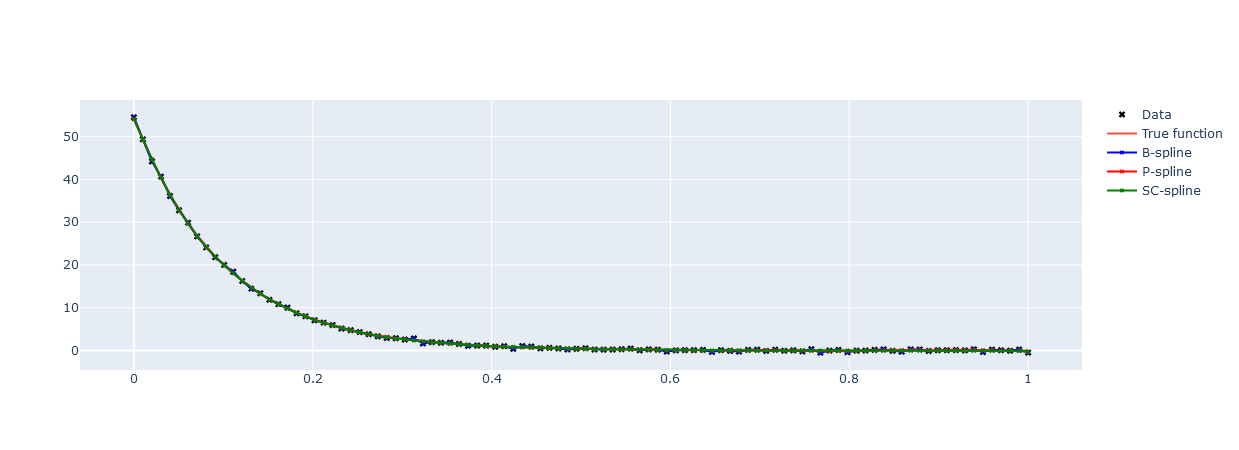

In [7]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y, mode="markers", marker=dict(size=6, color="black", symbol="x"), name="Data"))
fig.add_trace(go.Scatter(x=xplot, y=yplot, name="True function"))
fig.add_trace(go.Scatter(x=xplot, y=Bspred_plot, mode="markers+lines", marker=dict(size=4, color="blue", symbol="x"), name="B-spline"))
fig.add_trace(go.Scatter(x=xplot, y=Pspred_plot, mode="markers+lines", marker=dict(size=4, color="red", symbol="x"), name="P-spline"))
fig.add_trace(go.Scatter(x=xplot, y=SCspred_plot, mode="markers+lines", marker=dict(size=4, color="green", symbol="x"), name="SC-spline"))

#fig = BS.plot_basis(knots=Ps["knots"], coef=Ps["coef_"], x=xplot, fig=fig, l=l)
fig.show()

# 2. Test 2-D Fit using TP-spline, TP-P-spline and TP-SC-P-spline from *stareg*

In [12]:
np.random.seed(2)
#x1 = np.random.rand(1000)
#x2 = np.random.rand(1000)
x1 = np.linspace(0,1,5)
x1g, x2g = np.meshgrid(x1,x1)
data = np.vstack((x1g.ravel(),x2g.ravel())).T

def f(x1,x2): return np.exp(-(x2-0.5)**2) + x1**2

ztrue = f(data[:,0], data[:,1])
z = ztrue + np.random.normal(scale=0.1, size=len(ztrue))
df = pd.DataFrame(data=dict(x1=data[:,0], x2=data[:,1], z=z))
df_train, df_test = train_test_split(df)

In [13]:
xplot = np.linspace(0,1,25)
xplot1,xplot2 = np.meshgrid(xplot, xplot)
Xplot = np.vstack((xplot1.ravel(), xplot2.ravel())).T
zplot = f(xplot1.ravel(), xplot2.ravel())

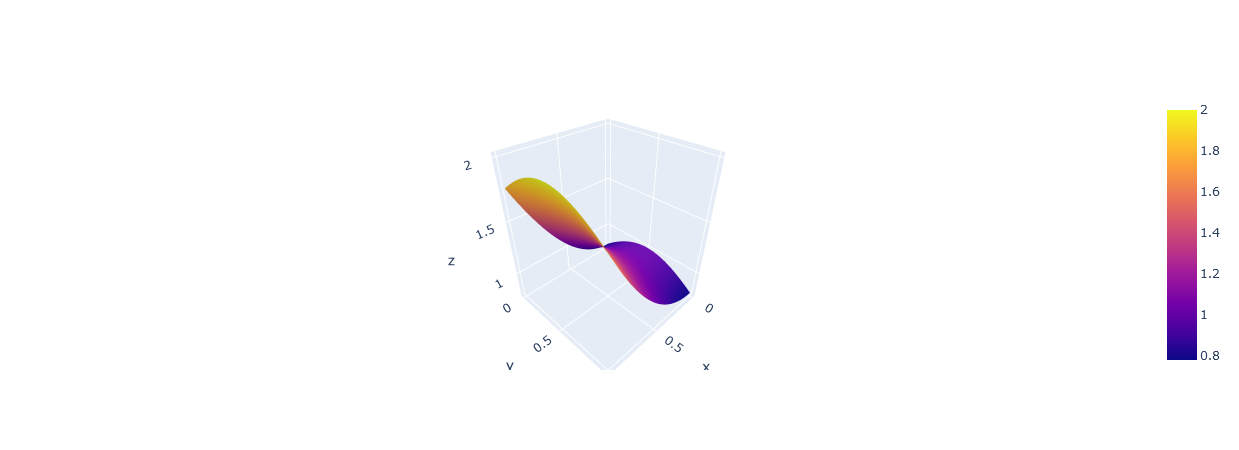

In [14]:
fig = go.Figure()
fig.add_trace(go.Surface(x=xplot1, y=xplot2, z=zplot.reshape(xplot1.shape)))

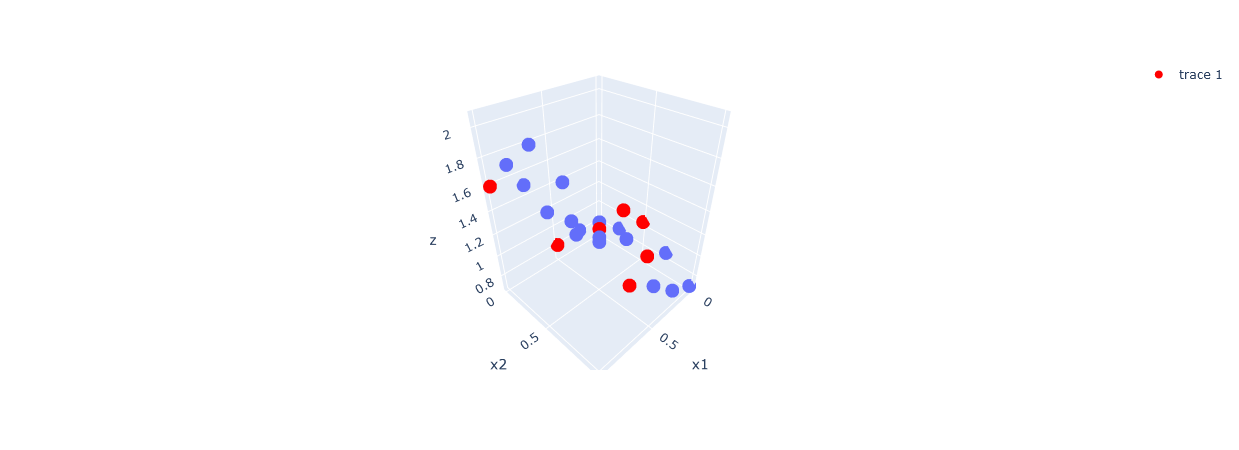

In [15]:
fig = px.scatter_3d(df_train, x="x1", y="x2", z="z")
fig.add_trace(go.Scatter3d(x=df_test["x1"], y=df_test["x2"], z=df_test["z"], mode="markers", marker=dict(color="red")))
fig.show()

In [16]:
nr_splines = (12,10)
l, knot_type = (3,3), ("e", "e")
BS = Bspline()
nr_lam = 100

 50%|██████████████████████████████████████████████████████████████████                                                                  | 10/20 [00:00<00:00, 85.45it/s]

Inside Bspline.basismatrix()
Inside Bspline.basismatrix()
Inside Bspline.basismatrix()
Inside Bspline.basismatrix()


 13%|████████████████▉                                                                                                                 | 13/100 [00:00<00:00, 129.97it/s]

Inside Bspline.basismatrix()
Inside Bspline.basismatrix()
Inside Bspline.basismatrix()
Inside Bspline.basismatrix()


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 125.41it/s]


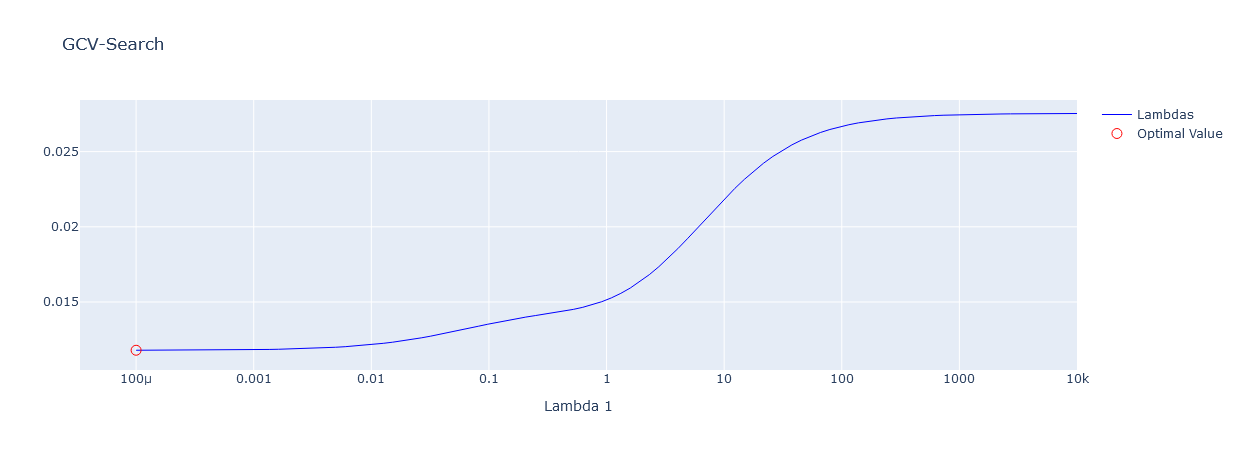

Inside Bspline.basismatrix()
Inside Bspline.basismatrix()
---unconstrained MSE = 0.0----
======== Iteration 1 =========
----------MSE = 0.0-----------
======== Iteration 2 =========
----------MSE = 0.0-----------
======== Iteration 3 =========
----------MSE = 0.0-----------


In [18]:
Bs = BS.fit(X=df_train[["x1", "x2"]].values, y=df_train["z"].values, 
            nr_splines=nr_splines, l=l, knot_type=knot_type)
best_lam=BS.calc_GCV_2d(df_train[["x1","x2"]].values, df_train["z"].values, nr_splines, nr_lam=20, plot_=0)
Ps = BS.fit_Pspline(X=df_train[["x1", "x2"]].values, y=df_train["z"].values, 
                    nr_splines=nr_splines, l=l, knot_type=knot_type, lam=best_lam["best_lambda"])
SCs = BS.fit_SC_TP_Pspline(X=df_train[["x1", "x2"]].values, y=df_train["z"].values,
                           constraints=("inc", "none"), nr_splines=nr_splines, l=l, knot_type=knot_type, lam_c=(6000,0))

In [19]:
Bspred = BS.predict(Xpred=df_test[["x1", "x2"]].values, coef=Bs["coef_"], knots=Bs["knots"], l=l)
Pspred = BS.predict(Xpred=df_test[["x1", "x2"]].values, coef=Ps["coef_"], knots=Ps["knots"], l=l)
SCspred = BS.predict(Xpred=df_test[["x1", "x2"]].values, coef=SCs["coef_"], knots=SCs["knots"], l=l)

Bspred_plot = BS.predict(Xpred=Xplot, coef=Bs["coef_"], knots=Bs["knots"], l=l)
Pspred_plot = BS.predict(Xpred=Xplot, coef=Ps["coef_"], knots=Ps["knots"], l=l)
SCspred_plot = BS.predict(Xpred=Xplot, coef=SCs["coef_"], knots=SCs["knots"], l=l)


---Prediction for 2-D Data----
---Prediction for 2-D Data----
---Prediction for 2-D Data----
---Prediction for 2-D Data----
---Prediction for 2-D Data----
---Prediction for 2-D Data----


In [22]:
lj = 30
print("MSE on Validation data".center(40,"="))
print("Tensor-product B-spline: ".ljust(lj), mean_squared_error(Bspred, df_test["z"]).round(6))
print("Tensor-product P-spline: ".ljust(lj), mean_squared_error(Pspred, df_test["z"]).round(6))
print("Tensor-product SC-P-spline: ".ljust(lj), mean_squared_error(SCspred, df_test["z"]).round(6))
print("MSE on True and Fine Grid data".center(40,"="))
print("Tensor-product B-spline: ".ljust(lj), mean_squared_error(Bspred_plot, zplot).round(6))
print("Tensor-product P-spline: ".ljust(lj), mean_squared_error(Pspred_plot, zplot).round(6))
print("Tensor-product SC-P-spline: ".ljust(lj), mean_squared_error(SCspred_plot, zplot).round(6))

=========MSE on Validation data=========
Tensor-product B-spline:       1.063593
Tensor-product P-spline:       0.019251
Tensor-product SC-P-spline:    0.017299
=====MSE on True and Fine Grid data=====
Tensor-product B-spline:       0.272158
Tensor-product P-spline:       0.00498
Tensor-product SC-P-spline:    0.005228


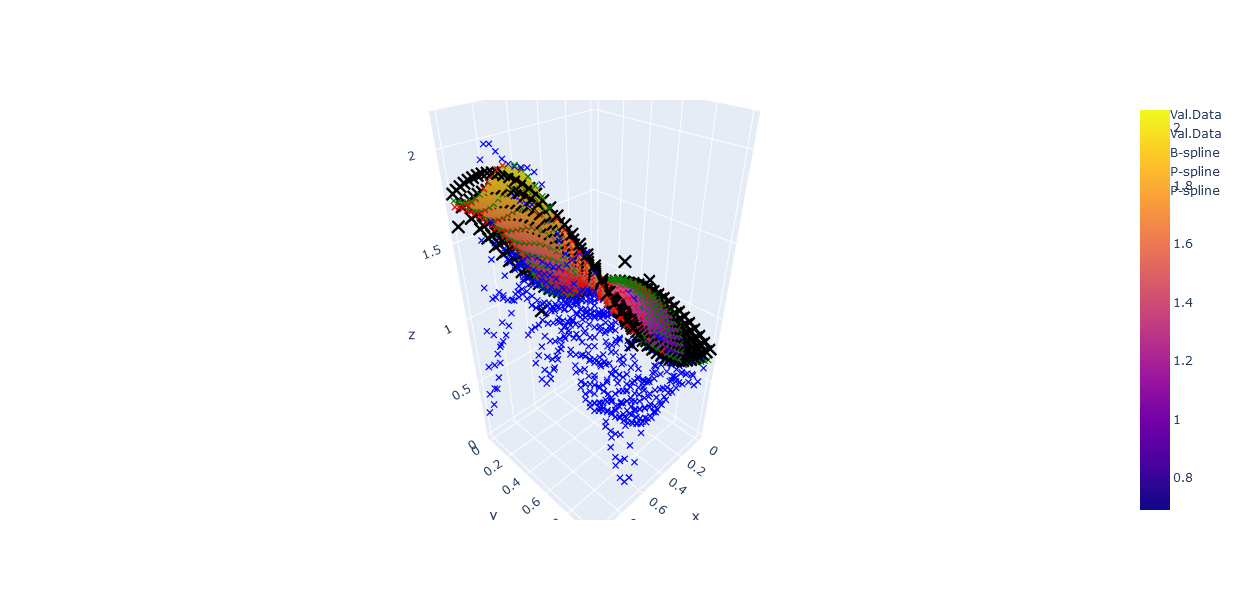

In [15]:
fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=df_test["x1"], y=df_test["x2"], z=df_test["z"], 
    mode="markers", marker=dict(color="black", symbol="x", size=4), name="Val.Data"))
fig.add_trace(go.Scatter3d(
    x=Xplot[:,0], y=Xplot[:,1], z=zplot, 
    mode="markers", marker=dict(color="black", symbol="x", size=4), name="Val.Data"))
fig.add_trace(go.Scatter3d(
    x=Xplot[:,0], y=Xplot[:,1], z=Bspred_plot, 
    mode="markers", marker=dict(color="blue", symbol="x", size=2), name="B-spline"))
fig.add_trace(go.Scatter3d(
    x=Xplot[:,0], y=Xplot[:,1], z=Pspred_plot, 
    mode="markers", marker=dict(color="red", symbol="x", size=2), name="P-spline"))
fig.add_trace(go.Scatter3d(
    x=Xplot[:,0], y=Xplot[:,1], z=SCspred_plot, 
    mode="markers", marker=dict(color="green", symbol="x", size=2), name="P-spline"))

#fig.add_trace(go.Surface(x=xplot1, y=xplot2, z=Pspred_plot.reshape(xplot1.shape)))
fig.add_trace(go.Surface(x=xplot1, y=xplot2, z=SCspred_plot.reshape(xplot1.shape)))

fig.update_layout(height=600)

In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from pathlib import Path

In [2]:
from stareg import star_model, star_model_predict

MEEEE and Moooooo and asdasdasd


## **STAR MODEL**

In [30]:
np.random.seed(2)
m = ( ("s(1)", 100, "inc", 6000, "e"), 
      #("s(2)", 100, "peak", 6000, "e"), 
      ("t(1,2)", (12,10), ("none", "none"), (6000,6000), ("e", "e")), )
      #("t(1,2)", (12,10), ("none", "none"), (6000,6000), ("e", "e")),)

XX = np.array([np.random.uniform(0,1,500), np.random.uniform(0,1, 500)]).T
#XX = np.array([np.linspace(0,1,25), np.linspace(1,11,25)]).T

y = XX[:,0]**2 * XX[:,1] + 2*np.exp(-(XX[:,1] - 0.6)**2) + np.random.normal(scale=0.02, size=XX[:,0].shape)

In [31]:
df = pd.DataFrame(data=dict(x1=XX[:,0], x2=XX[:,1], z=y))
df_train, df_test = train_test_split(df)

In [32]:
dim1, dim2 = int("t(1,2)"[2]), int("t(1,2)"[4])

In [33]:
descr = m
X = df_train[["x1", "x2"]].values
y = df_train["z"].values

 36%|███████████████████████████████████████████████▏                                                                                   | 18/50 [00:00<00:00, 174.72it/s]

Process  s(1)
Inside Bspline.basismatrix()
Inside Bspline.basismatrix()


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 167.75it/s]


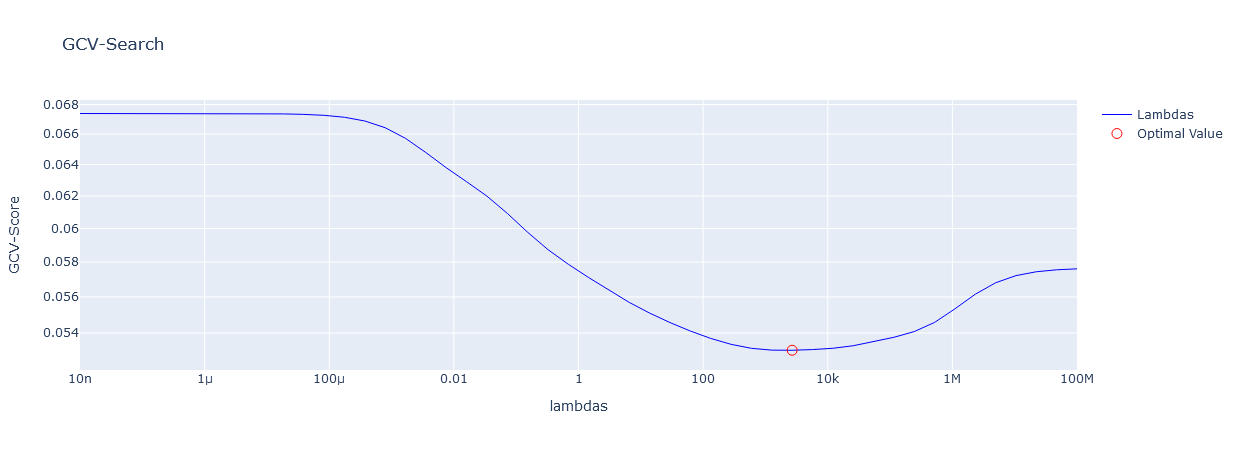

 26%|██████████████████████████████████                                                                                                 | 13/50 [00:00<00:00, 121.47it/s]

Inside Bspline.basismatrix()
Process  t(1,2)
Constraint =  ('none', 'none')
Inside Bspline.basismatrix()
Inside Bspline.basismatrix()
Inside Bspline.basismatrix()
Inside Bspline.basismatrix()


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 117.07it/s]


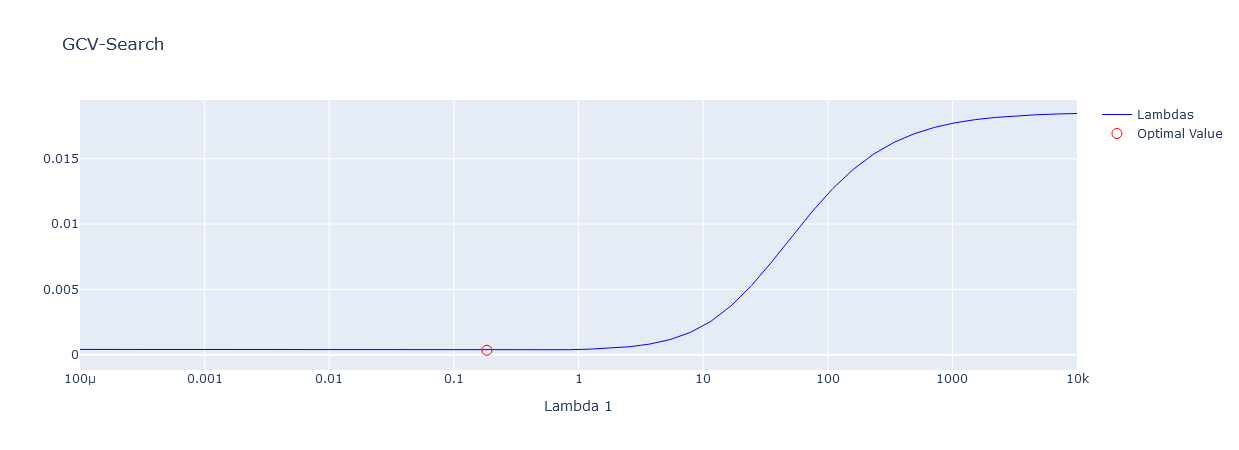

Inside Bspline.basismatrix()
Inside Bspline.basismatrix()
================== Iteration 1 ===================
-----------------MSE = 0.0002843------------------
--------Calculate new constraint matrix K---------
================== Iteration 2 ===================
-----------------MSE = 0.0002843------------------
--------Calculate new constraint matrix K---------
================== Iteration 3 ===================
-----------------MSE = 0.0002844------------------
--------Calculate new constraint matrix K---------
================== Iteration 4 ===================
-----------------MSE = 0.0002845------------------
--------Calculate new constraint matrix K---------
================== Iteration 5 ===================
-----------------MSE = 0.0002846------------------
--------Calculate new constraint matrix K---------
################Iteration Finished################


In [34]:
B, S, K, optimal_lambdas, coef_, weights = star_model(m, X, y)

## **Ebner Data**

### Load Data, perform Train-Validation Split and Normalized Input

In [35]:
np.random.seed(2)
savePath = os.path.join(os.path.dirname("."), '../../Thesis/tex/graphics/data/cha5/')
path = Path("..\\..\\Data\\")
df = pd.read_csv(filepath_or_buffer=path/"Table_alpha_Data.txt")
df.columns = ["mDot", "T", "HTC"]
maxVals, minVals = df.max(), df.min()
# train-test split
dftrain, dftest = train_test_split(df, test_size=0.5)
Xtrain, ytrain = dftrain[["mDot", "T"]].values, dftrain["HTC"].values
Xtest, ytest = dftest[["mDot", "T"]].values, dftest["HTC"].values
# normalized input data
Xtrain_norm = (Xtrain - minVals[["mDot", "T"]].values.reshape((-1,2))) / (maxVals - minVals)[["mDot", "T"]].values.reshape(-1,2)
Xtest_norm = (Xtest - minVals[["mDot", "T"]].values.reshape((-1,2))) / (maxVals - minVals)[["mDot", "T"]].values.reshape(-1,2)

### Create the model descriptions

In [36]:
model_list =["s1s2_WC", "s1s2", "t12_WC", "t12", "tot_WC", "tot"]
m_s1s2_without_constrait =  (("s(1)", 100, "none", 0, "e"), 
                             ("s(2)", 100, "none", 0, "e"), )
m_s1s2 = (("s(1)", 100, "inc", 1000, "e"), 
          ("s(2)", 100, "peak", 1000, "e"), )
m_t12_without_constraint = (("t(1,2)", (20,10), ("none", "none"), (0,0), ("e", "e")), )
m_t12 = (("t(1,2)", (20,10), ("inc", "none"), (6000,6000), ("e", "e")), )

m_tot_without_constraint = ( ("s(1)", 100, "none", 0, "e"), 
                             ("s(2)", 100, "none", 0, "e"),
                             ("t(1,2)", (20,10), ("none", "none"), (0,0), ("e", "e")), )
m_tot = ( ("s(1)", 100, "inc", 1000, "e"), 
          ("s(2)", 100, "peak", 1000, "e"),
          ("t(1,2)", (20,10), ("inc", "none"), (6000,6000), ("e", "e")), )

### Train the models

 40%|████████████████████████████████████████████████████▍                                                                              | 20/50 [00:00<00:00, 190.43it/s]

Process  s(1)
Inside Bspline.basismatrix()
Inside Bspline.basismatrix()


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 171.19it/s]


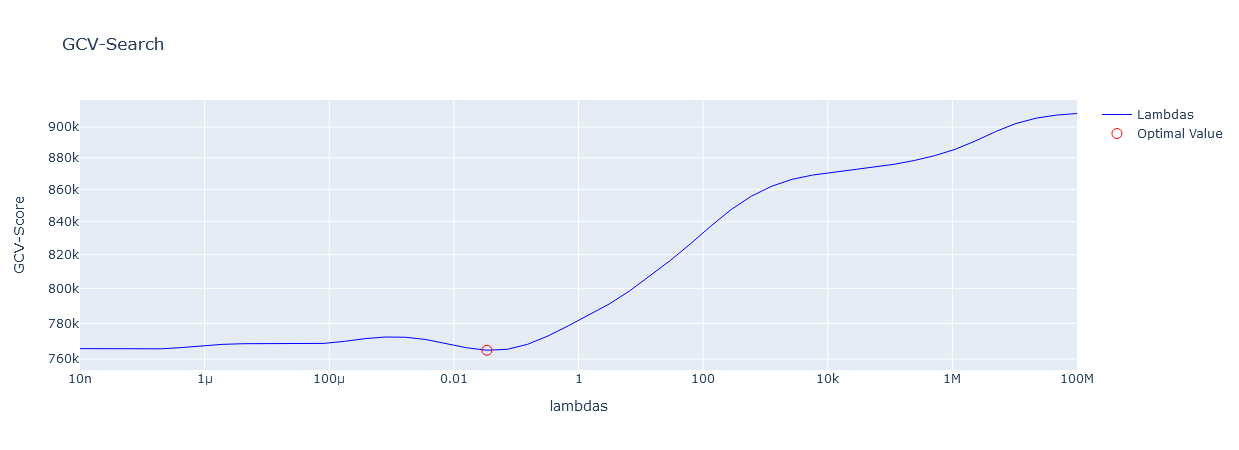

 32%|█████████████████████████████████████████▉                                                                                         | 16/50 [00:00<00:00, 158.38it/s]

Inside Bspline.basismatrix()
Process  s(2)
Inside Bspline.basismatrix()
Inside Bspline.basismatrix()


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 163.36it/s]


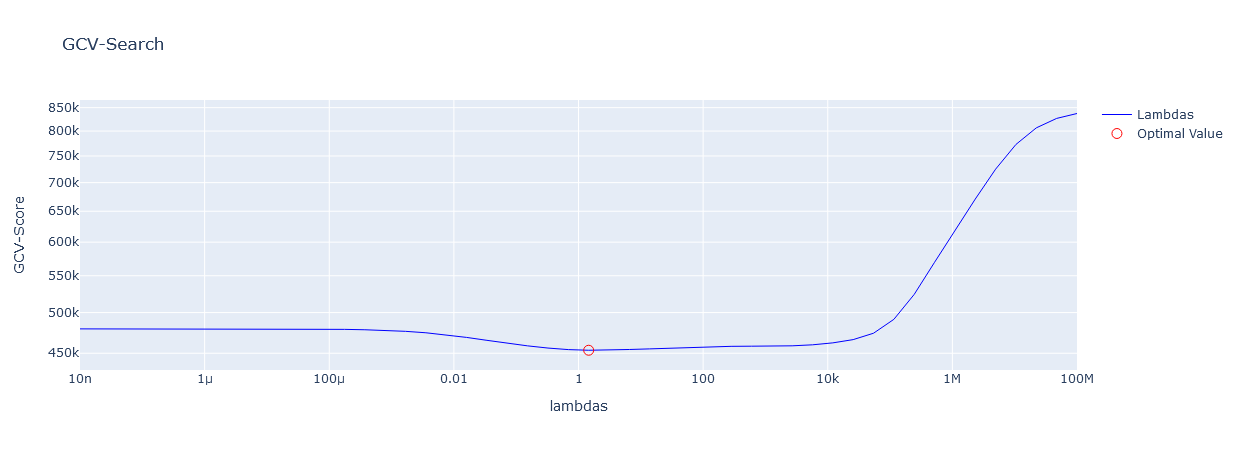

  0%|                                                                                                                                             | 0/50 [00:00<?, ?it/s]

Inside Bspline.basismatrix()
################Iteration Finished################
Process  s(1)
Inside Bspline.basismatrix()
Inside Bspline.basismatrix()


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 150.57it/s]


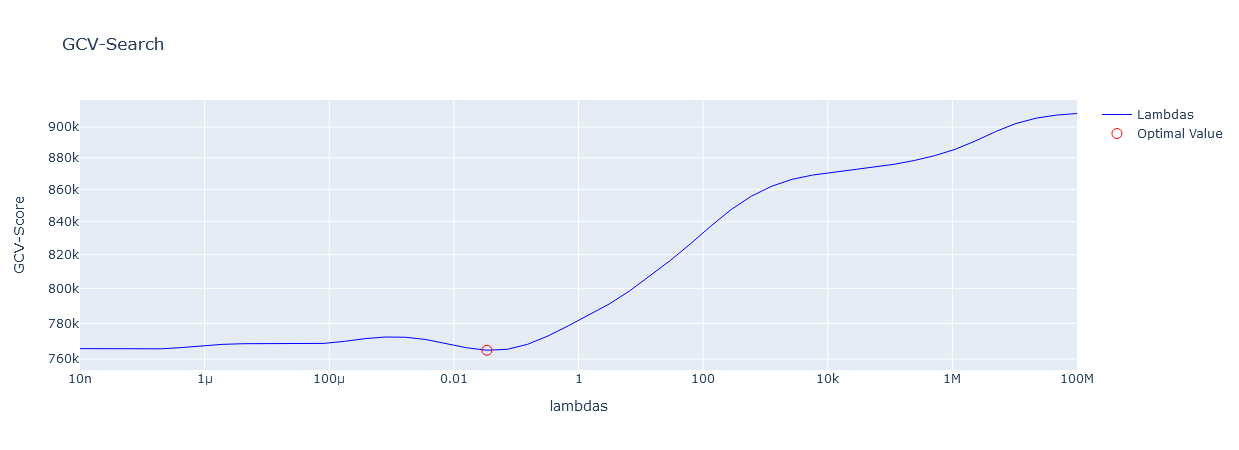

 36%|███████████████████████████████████████████████▏                                                                                   | 18/50 [00:00<00:00, 178.18it/s]

Inside Bspline.basismatrix()
Process  s(2)
Inside Bspline.basismatrix()
Inside Bspline.basismatrix()


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 146.59it/s]


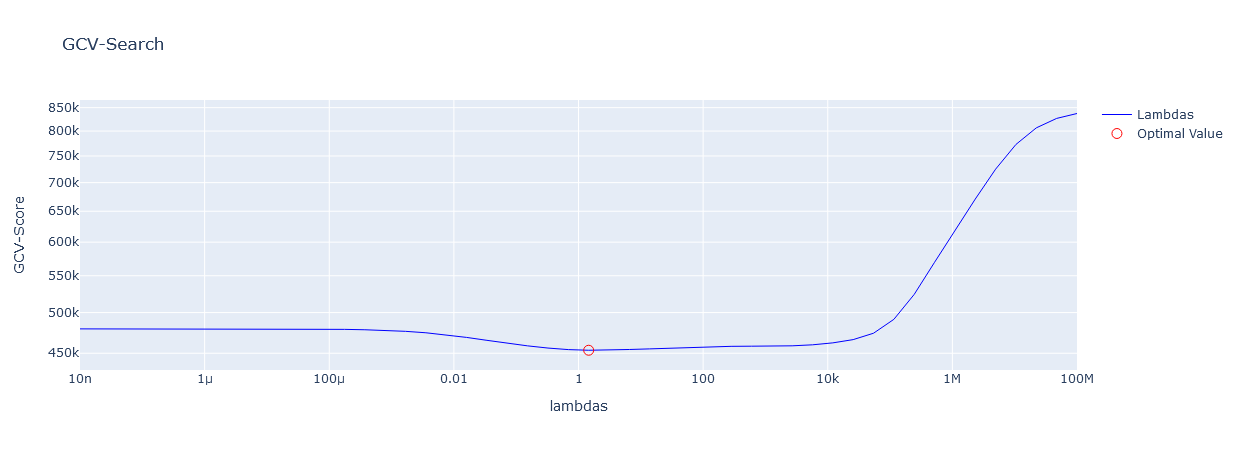

Inside Bspline.basismatrix()
================== Iteration 1 ===================
---------------MSE = 288653.9104098---------------
--------Calculate new constraint matrix K---------
================== Iteration 2 ===================
---------------MSE = 301975.4840136---------------
--------Calculate new constraint matrix K---------
================== Iteration 3 ===================
---------------MSE = 325717.8925387---------------
--------Calculate new constraint matrix K---------
================== Iteration 4 ===================
---------------MSE = 328306.8386923---------------
--------Calculate new constraint matrix K---------
================== Iteration 5 ===================

  0%|                                                                                                                                             | 0/50 [00:00<?, ?it/s]


---------------MSE = 328500.914515----------------
--------Calculate new constraint matrix K---------
================== Iteration 6 ===================
---------------MSE = 328431.9202448---------------
--------Calculate new constraint matrix K---------
================== Iteration 7 ===================
---------------MSE = 328431.9318365---------------
--------Calculate new constraint matrix K---------
################Iteration Finished################
Process  t(1,2)
Constraint =  ('none', 'none')
Inside Bspline.basismatrix()
Inside Bspline.basismatrix()
Inside Bspline.basismatrix()
Inside Bspline.basismatrix()


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 41.01it/s]


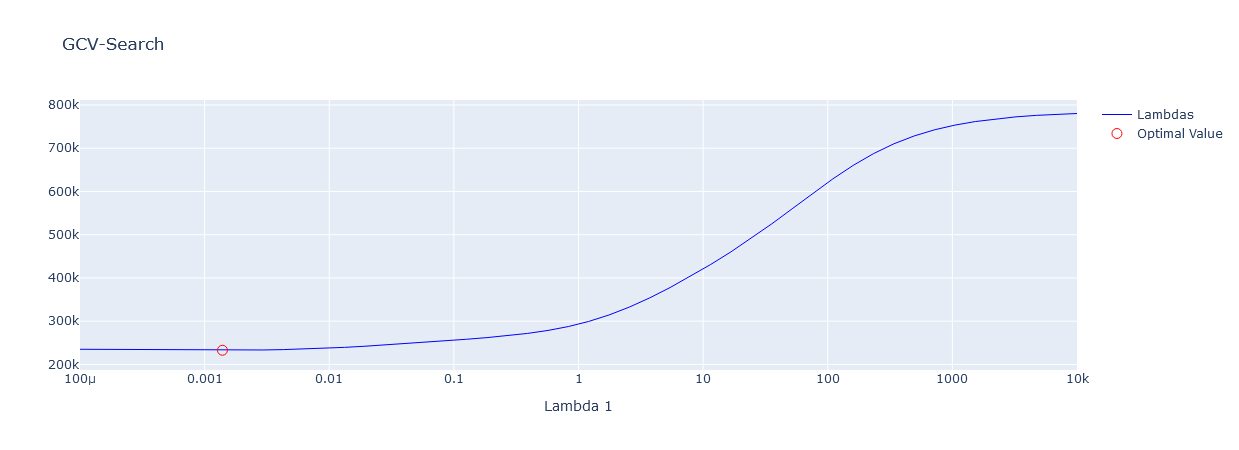

  0%|                                                                                                                                             | 0/50 [00:00<?, ?it/s]

Inside Bspline.basismatrix()
Inside Bspline.basismatrix()
################Iteration Finished################
Process  t(1,2)
Constraint =  ('inc', 'none')
Inside Bspline.basismatrix()
Inside Bspline.basismatrix()
Inside Bspline.basismatrix()
Inside Bspline.basismatrix()


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 43.56it/s]


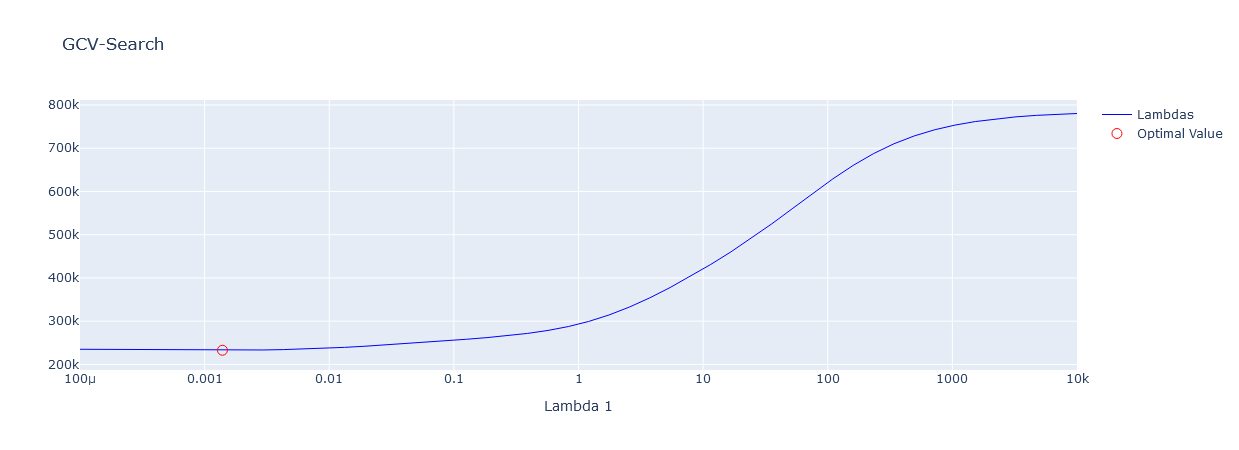

Inside Bspline.basismatrix()
Inside Bspline.basismatrix()
================== Iteration 1 ===================
---------------MSE = 209487.0433184---------------
--------Calculate new constraint matrix K---------
================== Iteration 2 ===================
---------------MSE = 223639.8500844---------------
--------Calculate new constraint matrix K---------
================== Iteration 3 ===================
---------------MSE = 235751.2790854---------------
--------Calculate new constraint matrix K---------
================== Iteration 4 ===================
---------------MSE = 237219.9973933---------------
--------Calculate new constraint matrix K---------
================== Iteration 5 ===================
---------------MSE = 238321.2267315---------------
--------Calculate new constraint matrix K---------
================== Iteration 6 ===================
---------------MSE = 238961.9911876---------------
--------Calculate new constraint matrix K---------
================== Itera

  0%|                                                                                                                                             | 0/50 [00:00<?, ?it/s]


---------------MSE = 239156.8240525---------------
--------Calculate new constraint matrix K---------
================== Iteration 9 ===================
---------------MSE = 239163.4177117---------------
--------Calculate new constraint matrix K---------
================== Iteration 10 ==================
---------------MSE = 239129.0569964---------------
--------Calculate new constraint matrix K---------
================== Iteration 11 ==================
---------------MSE = 239175.8829126---------------
--------Calculate new constraint matrix K---------
================== Iteration 12 ==================
---------------MSE = 239188.868579----------------
--------Calculate new constraint matrix K---------
================== Iteration 13 ==================
---------------MSE = 239188.428393----------------
--------Calculate new constraint matrix K---------
################Iteration Finished################
Process  s(1)
Inside Bspline.basismatrix()
Inside Bspline.basismatrix()


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 167.75it/s]


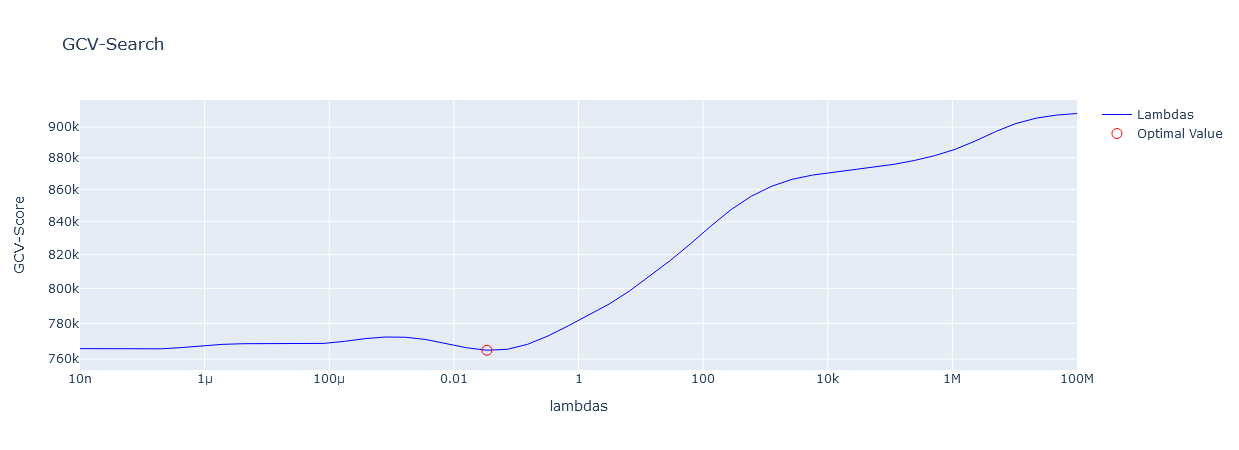

 28%|████████████████████████████████████▋                                                                                              | 14/50 [00:00<00:00, 134.58it/s]

Inside Bspline.basismatrix()
Process  s(2)
Inside Bspline.basismatrix()
Inside Bspline.basismatrix()


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 148.78it/s]


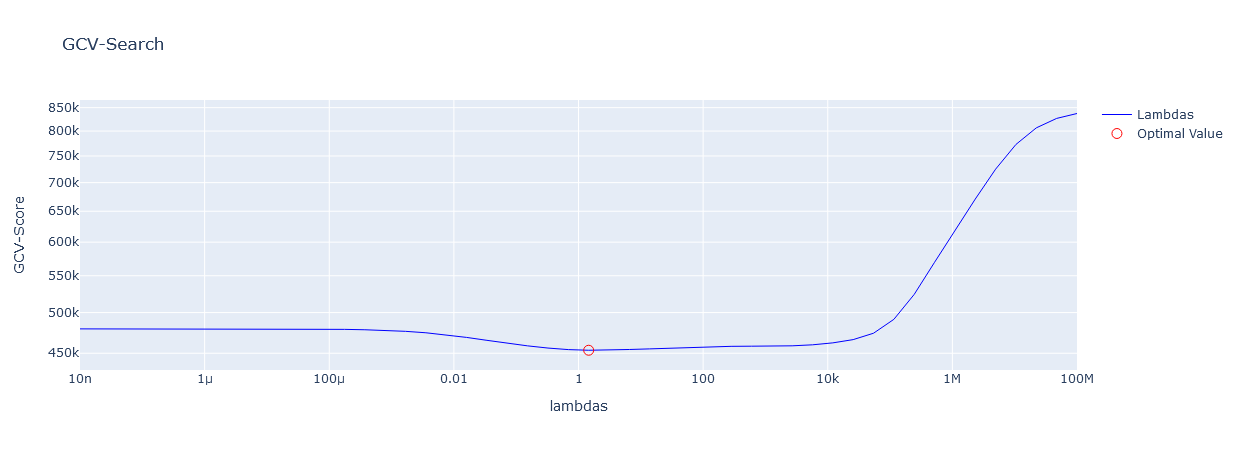

  0%|                                                                                                                                             | 0/50 [00:00<?, ?it/s]

Inside Bspline.basismatrix()
Process  t(1,2)
Constraint =  ('none', 'none')
Inside Bspline.basismatrix()
Inside Bspline.basismatrix()
Inside Bspline.basismatrix()
Inside Bspline.basismatrix()


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 43.04it/s]


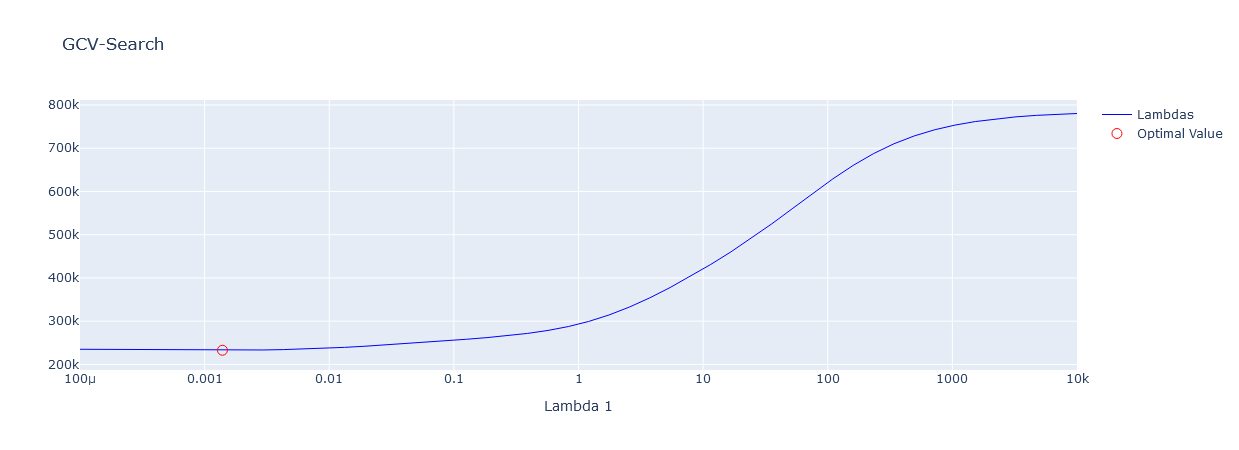

  0%|                                                                                                                                             | 0/50 [00:00<?, ?it/s]

Inside Bspline.basismatrix()
Inside Bspline.basismatrix()
################Iteration Finished################
Process  s(1)
Inside Bspline.basismatrix()
Inside Bspline.basismatrix()


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 140.81it/s]


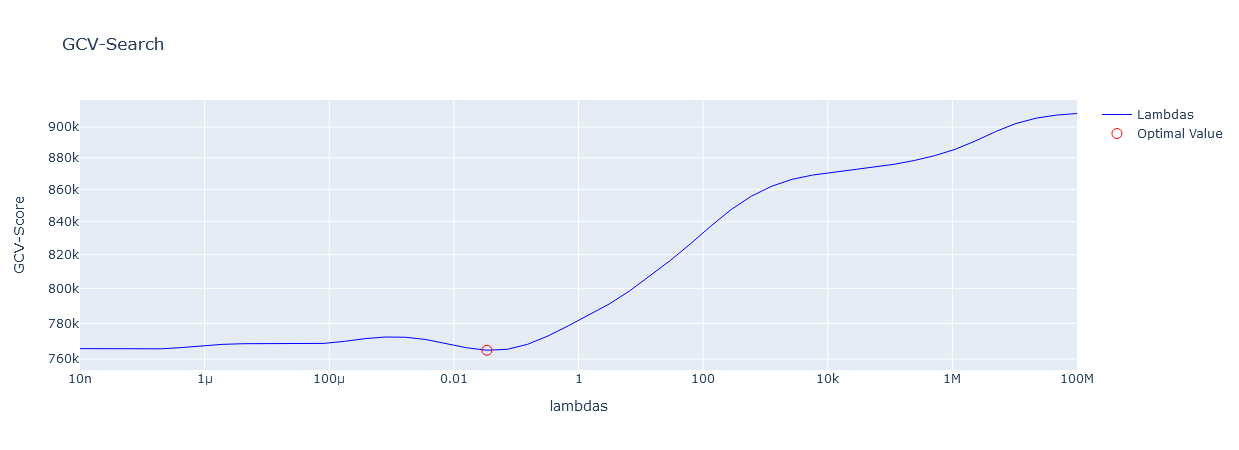

 36%|███████████████████████████████████████████████▏                                                                                   | 18/50 [00:00<00:00, 165.10it/s]

Inside Bspline.basismatrix()
Process  s(2)
Inside Bspline.basismatrix()
Inside Bspline.basismatrix()


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 148.33it/s]


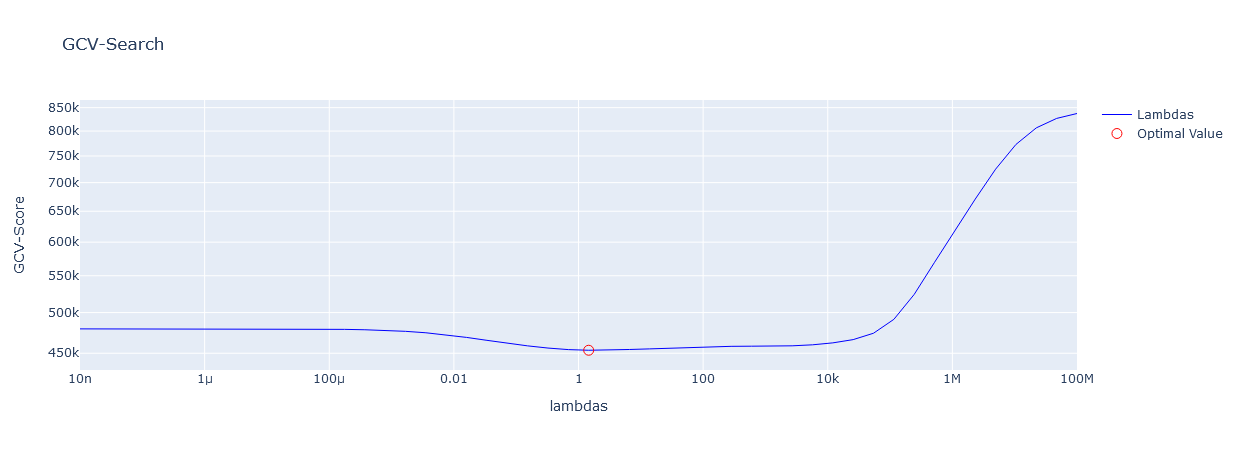

  0%|                                                                                                                                             | 0/50 [00:00<?, ?it/s]

Inside Bspline.basismatrix()
Process  t(1,2)
Constraint =  ('inc', 'none')
Inside Bspline.basismatrix()
Inside Bspline.basismatrix()
Inside Bspline.basismatrix()
Inside Bspline.basismatrix()


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 39.28it/s]


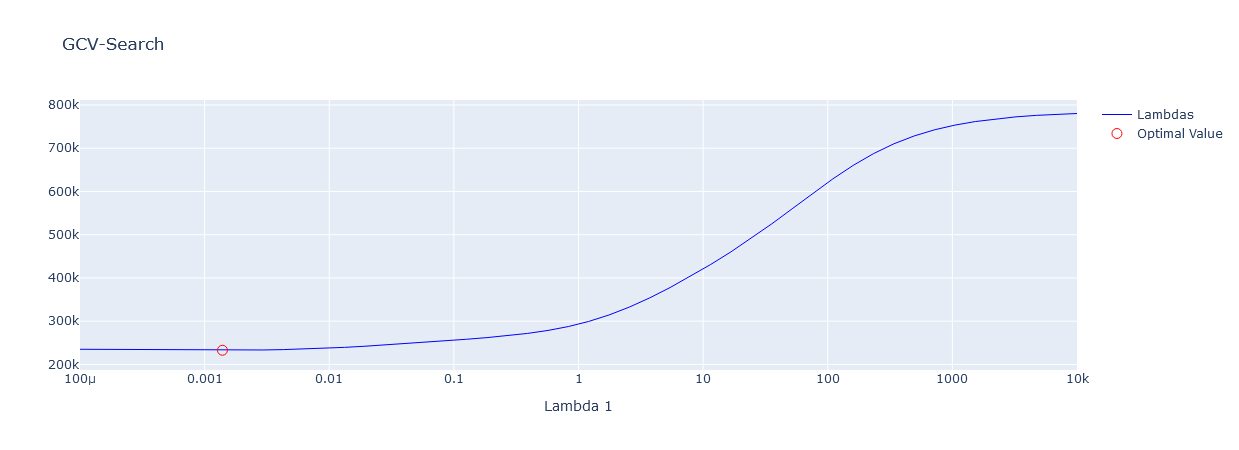

Inside Bspline.basismatrix()
Inside Bspline.basismatrix()
================== Iteration 1 ===================
---------------MSE = 171310.9860074---------------
--------Calculate new constraint matrix K---------
================== Iteration 2 ===================
---------------MSE = 183905.7683684---------------
--------Calculate new constraint matrix K---------
================== Iteration 3 ===================
---------------MSE = 205942.8160978---------------
--------Calculate new constraint matrix K---------
================== Iteration 4 ===================
---------------MSE = 214828.1480108---------------
--------Calculate new constraint matrix K---------
================== Iteration 5 ===================
---------------MSE = 216167.4503741---------------
--------Calculate new constraint matrix K---------
================== Iteration 6 ===================
---------------MSE = 216141.8739439---------------
--------Calculate new constraint matrix K---------
================== Itera

In [37]:
M1 = star_model(descr=m_s1s2_without_constrait, X=Xtrain_norm, y=ytrain)
M2 = star_model(descr=m_s1s2, X=Xtrain_norm, y=ytrain)
M3 = star_model(descr=m_t12_without_constraint, X=Xtrain_norm, y=ytrain)
M4 = star_model(descr=m_t12, X=Xtrain_norm, y=ytrain)
M5 = star_model(descr=m_tot_without_constraint, X=Xtrain_norm, y=ytrain)
M6 = star_model(descr=m_tot, X=Xtrain_norm, y=ytrain)

### Calculate the predictions for the validation Data

In [38]:
M1pred = star_model_predict(Xpred=Xtest_norm, coefs=M1["coef_"], descr=m_s1s2_without_constrait)
M2pred = star_model_predict(Xpred=Xtest_norm, coefs=M2["coef_"], descr=m_s1s2)
M3pred = star_model_predict(Xpred=Xtest_norm, coefs=M3["coef_"], descr=m_t12_without_constraint)
M4pred = star_model_predict(Xpred=Xtest_norm, coefs=M4["coef_"], descr=m_t12)
M5pred = star_model_predict(Xpred=Xtest_norm, coefs=M5["coef_"], descr=m_tot_without_constraint)
M6pred = star_model_predict(Xpred=Xtest_norm, coefs=M6["coef_"], descr=m_tot)

Process  s(1)
Inside Bspline.basismatrix()
Process  s(2)
Inside Bspline.basismatrix()
Process  s(1)
Inside Bspline.basismatrix()
Process  s(2)
Inside Bspline.basismatrix()
Process  t(1,2)
Inside Bspline.basismatrix()
Inside Bspline.basismatrix()
Process  t(1,2)
Inside Bspline.basismatrix()
Inside Bspline.basismatrix()
Process  s(1)
Inside Bspline.basismatrix()
Process  s(2)
Inside Bspline.basismatrix()
Process  t(1,2)
Inside Bspline.basismatrix()
Inside Bspline.basismatrix()
Process  s(1)
Inside Bspline.basismatrix()
Process  s(2)
Inside Bspline.basismatrix()
Process  t(1,2)
Inside Bspline.basismatrix()
Inside Bspline.basismatrix()


### Print MSE on Validation Data

In [39]:
MSE_M1 = mean_squared_error(ytest, M1pred["y"])
MSE_M2 = mean_squared_error(ytest, M2pred["y"])
MSE_M3 = mean_squared_error(ytest, M3pred["y"])
MSE_M4 = mean_squared_error(ytest, M4pred["y"])
MSE_M5 = mean_squared_error(ytest, M5pred["y"])
MSE_M6 = mean_squared_error(ytest, M6pred["y"])

r, lj = 8, 20
print("".center(50,"="))
print("MSEs on Validation Data".center(50, " "))
print("".center(50,"="))
print(f"{model_list[0]}-MSE = ".ljust(lj), MSE_M1)
print(f"{model_list[1]}-MSE = ".ljust(lj), MSE_M2)
print(f"{model_list[2]}-MSE = ".ljust(lj), MSE_M3)
print(f"{model_list[3]}-MSE = ".ljust(lj), MSE_M4)
print(f"{model_list[4]}-MSE = ".ljust(lj), MSE_M5)
print(f"{model_list[5]}-MSE = ".ljust(lj), MSE_M6)

df_mses = pd.DataFrame(
    data=dict(Model=["M1","M2","M3","M4","M5","M6"], MSE_val=[MSE_M1, MSE_M2, MSE_M3, MSE_M4, MSE_M5, MSE_M6]))

             MSEs on Validation Data              
s1s2_WC-MSE =        1379345.0668153937
s1s2-MSE =           345560.028785705
t12_WC-MSE =         213959.50480378082
t12-MSE =            204717.04082819537
tot_WC-MSE =         4361713.326753145
tot-MSE =            214814.7770489283


### Calculate the predictions for the training Data

In [11]:
M1pred_Train = star_model_predict(Xpred=Xtrain_norm, coefs=M1["coef_"], descr=m_s1s2_without_constrait)
M2pred_Train = star_model_predict(Xpred=Xtrain_norm, coefs=M2["coef_"], descr=m_s1s2)
M3pred_Train = star_model_predict(Xpred=Xtrain_norm, coefs=M3["coef_"], descr=m_t12_without_constraint)
M4pred_Train = star_model_predict(Xpred=Xtrain_norm, coefs=M4["coef_"], descr=m_t12)
M5pred_Train = star_model_predict(Xpred=Xtrain_norm, coefs=M5["coef_"], descr=m_tot_without_constraint)
M6pred_Train = star_model_predict(Xpred=Xtrain_norm, coefs=M6["coef_"], descr=m_tot)

Process  s(1)
Process  s(2)
Process  s(1)
Process  s(2)
Process  t(1,2)
Process  t(1,2)
Process  s(1)
Process  s(2)
Process  t(1,2)
Process  s(1)
Process  s(2)
Process  t(1,2)


### Print MSE on training data

In [14]:
MSE_M1_train = mean_squared_error(ytrain, M1pred_Train["y"])
MSE_M2_train = mean_squared_error(ytrain, M2pred_Train["y"])
MSE_M3_train = mean_squared_error(ytrain, M3pred_Train["y"])
MSE_M4_train = mean_squared_error(ytrain, M4pred_Train["y"])
MSE_M5_train = mean_squared_error(ytrain, M5pred_Train["y"])
MSE_M6_train = mean_squared_error(ytrain, M6pred_Train["y"])

r, lj = 8, 20
print("".center(50,"="))
print("MSEs on Training Data".center(50, " "))
print("".center(50,"="))
print(f"{model_list[0]}-MSE = ".ljust(lj), MSE_M1_train)
print(f"{model_list[1]}-MSE = ".ljust(lj), MSE_M2_train)
print(f"{model_list[2]}-MSE = ".ljust(lj), MSE_M3_train)
print(f"{model_list[3]}-MSE = ".ljust(lj), MSE_M4_train)
print(f"{model_list[4]}-MSE = ".ljust(lj), MSE_M5_train)
print(f"{model_list[5]}-MSE = ".ljust(lj), MSE_M6_train)

              MSEs on Training Data               
s1s2_WC-MSE =        1277788.7711937097
s1s2-MSE =           328431.9318365129
t12_WC-MSE =         182338.2689235734
t12-MSE =            239188.42839297466
tot_WC-MSE =         4628493.163665841
tot-MSE =            216986.4734746153


### Plotting 

In [37]:
xplot = np.linspace(0,1,25)
xp1, xp2 = np.meshgrid(xplot, xplot)
Xplot = np.array([xp1.ravel(), xp2.ravel()]).T

Process  t(1,2)


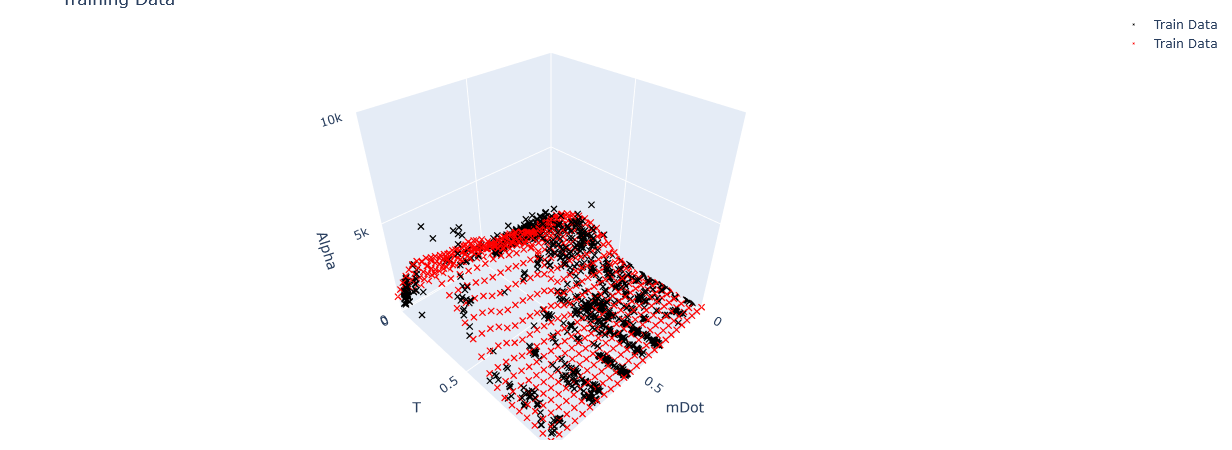

In [40]:
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=Xtest_norm[:,0], y=Xtest_norm[:,1], z=ytest, mode="markers", marker=dict(size=2, color="black", symbol="x"), name="Train Data"))
fig.add_trace(go.Scatter3d(x=Xplot[:,0], y=Xplot[:,1], z=star_model_predict(Xpred=Xplot, coefs=M4["coef_"], descr=m_t12)["y"], 
                           mode="markers", marker=dict(size=2, color="red", symbol="x"), name="Train Data"))
fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=4, range=[0,1],title="mDot"),
        yaxis = dict(nticks=4, range=[0,1],title="T"),
        zaxis = dict(nticks=4, range=[-100,10000],title="Alpha"),),
    width=700,
    margin=dict(r=20, l=10, b=10, t=10),
    title="Training Data")

### Data Saving

In [41]:
xsave = np.linspace(0,1,25)
xs1, xs2 = np.meshgrid(xplot, xplot)
Xsave = np.array([xp1.ravel(), xp2.ravel()]).T
M1save = star_model_predict(Xpred=Xsave, coefs=M1["coef_"], descr=m_s1s2_without_constrait)
M2save = star_model_predict(Xpred=Xsave, coefs=M2["coef_"], descr=m_s1s2)
M3save = star_model_predict(Xpred=Xsave, coefs=M3["coef_"], descr=m_t12_without_constraint)
M4save = star_model_predict(Xpred=Xsave, coefs=M4["coef_"], descr=m_t12)
M5save = star_model_predict(Xpred=Xsave, coefs=M5["coef_"], descr=m_tot_without_constraint)
M6save = star_model_predict(Xpred=Xsave, coefs=M6["coef_"], descr=m_tot)

Process  s(1)
Process  s(2)
Process  s(1)
Process  s(2)
Process  t(1,2)
Process  t(1,2)
Process  s(1)
Process  s(2)
Process  t(1,2)
Process  s(1)
Process  s(2)
Process  t(1,2)


In [42]:
Xsave_rescaled = Xsave * (maxVals[["mDot", "T"]] - minVals[["mDot", "T"]]).values.reshape(-1,2) + minVals[["mDot", "T"]].values.reshape(-1,2)

In [47]:
df_save_fits = pd.DataFrame(
    data=dict(x1=Xsave_rescaled[:,0], x2=Xsave_rescaled[:,1], M1=M1save["y"], 
              M2=M2save["y"],M3=M3save["y"], M4=M4save["y"], 
              M5=M5save["y"], M6=M6save["y"]))
df_save_data = pd.DataFrame(
    data=dict(x1=Xtest[:,0], x2=Xtest[:,1], y=ytest, x1train=Xtrain[:,0], x2train=Xtrain[:,1], ytrain=ytrain))

df_info = pd.DataFrame(
    data=dict(model=model_list, nr_splines=[(100,100), (100,100), ((20,10),), ((20,10),), (100,100,(20,10),), (100,100, (20,10),)], 
              opt_lambda=[M1["opt_lambdas"], M2["opt_lambdas"], M3["opt_lambdas"], M4["opt_lambdas"], M5["opt_lambdas"], M6["opt_lambdas"]]))

In [74]:
saveFiles = input("Save Files?")
if saveFiles == "y":
    print("Save files to ", savePath)
    df_save_data.to_csv(savePath+"data.txt", sep=" ", index=0)
    df_save_fits.to_csv(savePath+"fits.txt", sep=" ", index=0)
    df_mses.to_csv(savePath+"mses.csv", sep=",", index=0)
    df_info.to_csv(savePath+"info.txt", sep=" ", index=0)
else:
    print("Don't save files.")

Save Files? y


Save files to  ../../Thesis/tex/graphics/data/cha5/


In [65]:
ytrain.min(axis=0)

12.817018990814411

In [68]:
df.max()

mDot      10.568003
T        806.840000
HTC     6853.696237
dtype: float64